<a href="https://colab.research.google.com/github/eemaansheikh/Data_Science_2025/blob/main/EemaanSheikh_Unit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

**CONTEXT**
For this project, I analyzed how the number of years working as a data scientist affects salary. This data set is expected to be linear since people generally tend to make more at a job when working at it for a longer time.

In [3]:
#load the data into a pandas dataframe, and print it
url_salary = 'https://raw.githubusercontent.com/eemaansheikh/Data_Science_2025/main/unit%205%20data%20-%20Sheet3.csv'
#I could have put the url string directly into pd.read_csv()
salary = pd.read_csv(url_salary,dtype={'Pos':'category'})

In [4]:
salary

,Year,Salary
0,2,115000
1,2,115000
2,2,115000
3,2,115000
4,2,115000
...,...,...
448,24,240000
449,24,240000
450,24,240000
451,24,240000


<Axes: xlabel='Year', ylabel='Salary'>

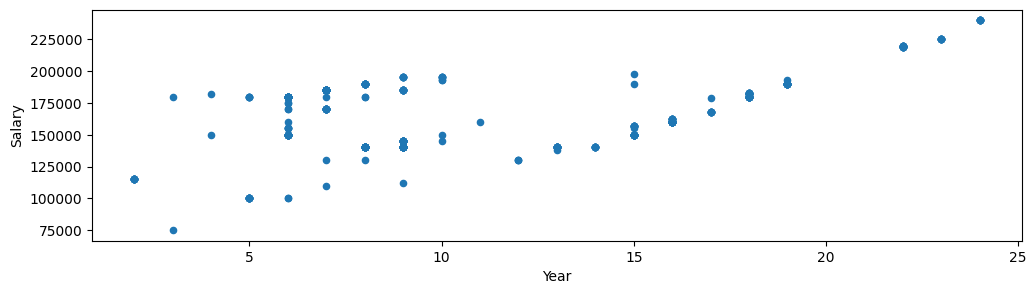

In [5]:
salary.plot(x="Year", y="Salary", figsize=(12, 3), kind="scatter")

Basic plotting of data shows to be most linear with a slight right skew.

Since it was linear data, I plotted it with a normal prior since it didn't have any crazy outliers and all the numbers were positive.

Text(0, 0.5, 'Salary')

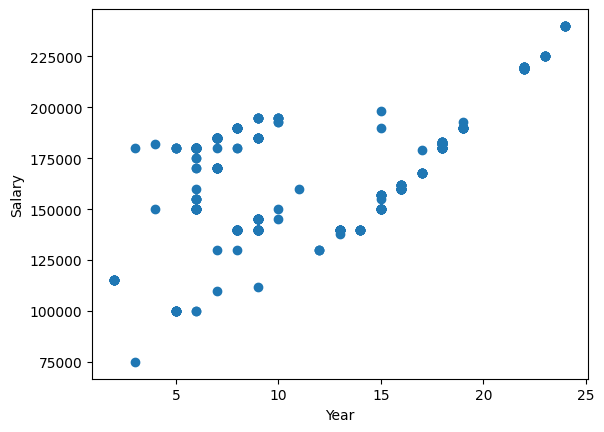

In [6]:
plt.scatter(salary['Year'] , salary['Salary'],)

#label axes
plt.xlabel("Year")
plt.ylabel("Salary")

In [ ]:
#lb stands for linear bike
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=1000)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * salary.Year)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=salary.Salary)

    #inference data object
    idata_lb = pm.sample()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

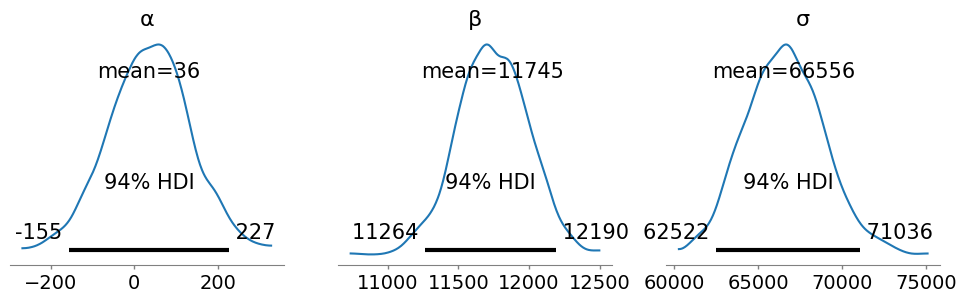

In [63]:
#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

In [ ]:
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

Text(0, 0.5, 'Salary')

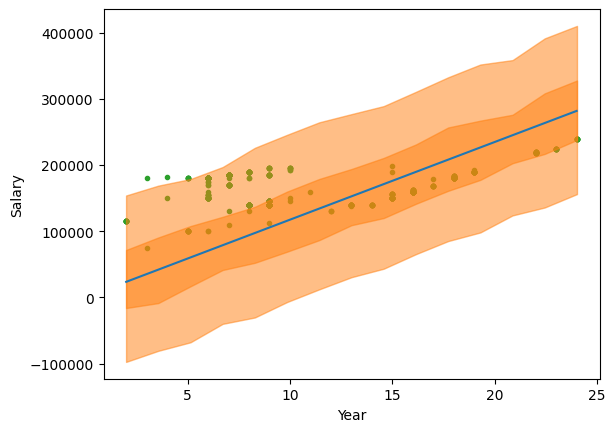

In [65]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
Year = np.random.normal(salary.Year.values, 0.01)
idx = np.argsort(Year)
x = np.linspace(Year.min(), Year.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(Year[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(salary.Year, salary.Salary, "C2.", zorder=-3)
ax.plot(salary.Year[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Year")
ax.set_ylabel("Salary")

Initially, my linear regreession was a fully horizontal orange patch and was not representative of my data. I tried changing my distribution from Normal to SkewNormal, StudentT, HalfStudentT, and Gamma until I realized that Normal had the best fit. Eventually, I had to change the Beta for the normal distribution to 1000 in order to represent the y-axis in a more accurate way, bringing the output above.

<Axes: xlabel='y_pred'>

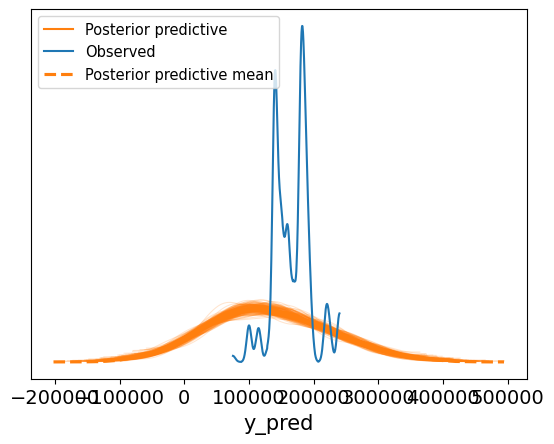

In [76]:
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

My Posterior Predictive and variable variance posterior still isn't accurate. I'm still not sure how to fix this since I tried multiple distributions already and tried removing the sqrt function, but those turned out much less accurate (one solid blue vertical line).

In [ ]:
#sqrtba stands for square root babies
with pm.Model() as model_sqrtba:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=1000)

    #mean line
    μ = pm.Deterministic("μ", α + β *pm.math.sqrt(salary.Year))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=salary.Salary)

    idata_sqrtba = pm.sample()

Text(0, 0.5, 'Salary')

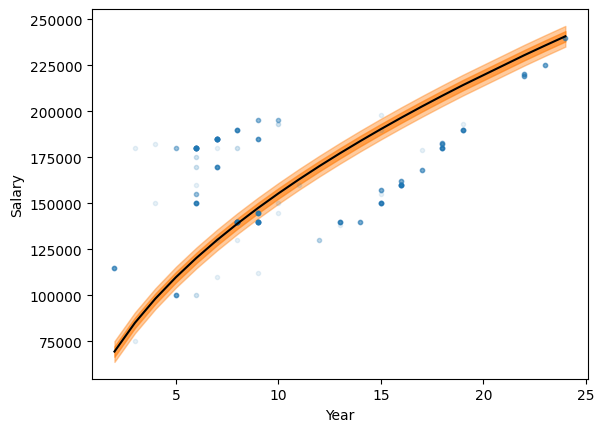

In [85]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(salary.Year, salary.Salary, "C0.", alpha=0.1)

posterior_sqrtba = az.extract(idata_sqrtba)

μ_m = posterior_sqrtba["μ"].mean("sample").values
σ_m = posterior_sqrtba["σ"].mean("sample").values

ax.plot(salary.Year, μ_m, c="k")
ax.fill_between(salary.Year, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(salary.Year, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("Year")
ax.set_ylabel("Salary")

In [ ]:
pm.sample_posterior_predictive(
    idata_sqrtba, model = model_sqrtba, extend_inferencedata=True
    )

<Axes: xlabel='y_pred'>

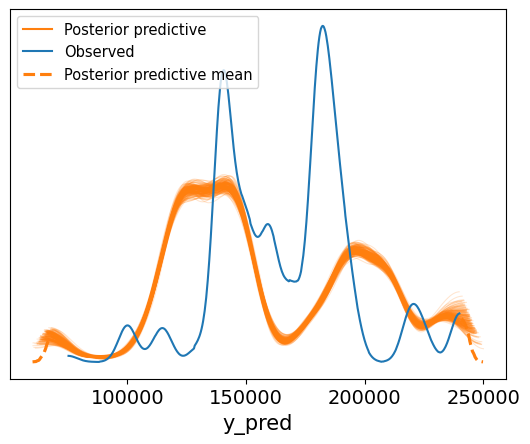

In [88]:
az.plot_ppc(idata_sqrtba, num_pp_samples=200, colors=["C1", "C0", "C1"])

The shape of this linear regression model and posterior fits better but is far from perfect. Once again, I changed sigma for the normal function to 1000 to better fit the y axis for the linear regression. While the shape of the posterior predictive better matches up, the line is still too tall and not very fitting to the shape. I'm still not sure how to fix this.

**CONCLUSION**
My data was not as linear as I expected it to be. While it had an overall linear shape, I don't think I found the correct posterior predictive to represent it.